# DL2 - Sheet 02: Attention (50 points)



In [2]:
# Install the transformers library if necessary
# pip install transformers
import transformers
print(transformers.__version__)

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]

4.40.1



# Intro: Transformers for Sequence Classification

In this weeks notebook, we will implement our own Transformer model from scratch. Typical Transformers can be broken down into the following components:
Remark: Here, we will focus on the encoding of sentences for the purpose of sentiment classification, the decoder used in sequence2sequences Transformers has a very similar structure.



1.   Embedding: An embedding layer that transforms word tokens into vector representations.
2.  Encoder: The encoder block consists of several multi-headed attention blocks

    2.1.   Attention block 1

    2.2.   Attention block 2

    ...

    2.L.   Attention block L

3. Pooling: The final output of the encoder computes one vector representation for each token. To further summarize/pool this information for classification, the [CLS] token at sequence position 0 is typically selected.

4. Classification: A standard small MLP is used for classification and outputs probabilites for the most likely predicted class.


## Preparation: From sentences to tokens

First, we will use hugginface's tokenizer to go from words to indices in the vocabulary. In the following, we will focus on the distilBERT model:


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
sentence = "This was one of the best movies I have ever seen."
inputs = tokenizer(sentence, return_tensors = 'pt')
print(inputs)

c:\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\memmi\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate develo

{'input_ids': tensor([[ 101, 2023, 2001, 2028, 1997, 1996, 2190, 5691, 1045, 2031, 2412, 2464,
         1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [11]:
# Now we download pretrained weights for the model.
! wget https://tubcloud.tu-berlin.de/s/GfEoq4r8Sgb2727/download/distilbert.pt

In [5]:
# This config contains the model parameters, it will be important to understand what representations 
# have which dimensionality

from torch import nn
import torch
import math
import torch

class Config(object):
    def __init__(self):
        self.n_heads = 12
        self.n_layers = 6
        self.pad_token_id = 0
        self.dim = 768
        self.hidden_dim = 3072
        self.max_position_embeddings = 512
        self.vocab_size = 30522
        self.eps = 1e-12

        self.attention_head_size = int(self.dim / self.n_heads)
        self.all_head_size = self.n_heads * self.attention_head_size

        self.n_classes = 2        
        self.device = 'cpu'

config = Config()

# 1. Embedding Layer (5p)
Next, we will have to implement the Embedding layer. 


1.   forward: compute the output embeddings from the input_embeds and position_embeds. (Think about how they are merged.)




In [6]:
torch.manual_seed(0) # set seed for reproducible random initialization of weights

class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.dim, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.dim)
        self.LayerNorm = nn.LayerNorm(config.dim, eps=config.eps)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            input_ids (torch.Tensor):
                torch.tensor(bs, max_seq_length) The token ids to embed.
        Returns: torch.tensor(bs, max_seq_length, dim) The embedded tokens (plus position embeddings)
        """
 
        # Embedding the input ids
        input_embeds = self.word_embeddings(input_ids)  # (bs, max_seq_length, dim)
        seq_length = input_embeds.size(1)

        # Creating and embedding the position ids  
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)  # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)  # (bs, max_seq_length)
        position_embeddings = self.position_embeddings(position_ids)  # (bs, max_seq_length, dim)

        # Compute the output embeddings
        
        # 1. START YOUR CODE HERE #
        embeddings = input_embeds + position_embeddings
        # 1. END YOUR CODE HERE #

        embeddings = self.LayerNorm(embeddings)  # (bs, max_seq_length, dim)
        return embeddings

embedding_layer = Embeddings(config)
# Test if your embedding layer computes an output
embeddings = embedding_layer(inputs['input_ids'])


In [7]:
print(embeddings)

tensor([[[ 0.7850, -0.1792, -0.7408,  ..., -0.3442, -0.2749, -0.4575],
         [ 0.3348, -0.6993,  0.9561,  ...,  0.2761, -1.1587,  0.7851],
         [ 0.2848, -0.3849,  1.1479,  ...,  0.0363, -0.7349,  1.1516],
         ...,
         [ 0.0217, -0.4367,  0.5442,  ...,  0.3884, -0.7516,  0.6763],
         [ 0.6787,  0.4753,  0.0463,  ...,  1.3417, -1.0327,  1.0803],
         [-0.2996,  0.0238,  0.8504,  ..., -1.1545, -0.5847, -0.9615]]],
       grad_fn=<NativeLayerNormBackward0>)


# 2. Attention Block (20 points)
The next step is writing the attention block. It mainly consits of the self-attention function (that you have analyzed in the first part of the exercise sheet), a layer normalization followed by an additional projection layer.

Please add the missing code:


1.   \_\_init\_\_: Add the Linear projections for the query, key and value functions. Make sure your set the correct dimensions.
2.   forward: Write the main self-attention function. Follow the three main steps as indicated in the comments below.




In [8]:
torch.manual_seed(0)

class AttentionBlock(nn.Module):    
    def __init__(self, config):
        super().__init__()
        self.config = config

        # self-attention components
        
        # 1. START YOUR CODE HERE #
        self.q_lin = nn.Linear(in_features=config.dim, out_features=config.all_head_size, bias=True)
        self.k_lin = nn.Linear(in_features=config.dim, out_features=config.all_head_size, bias=True)
        self.v_lin = nn.Linear(in_features=config.dim, out_features=config.all_head_size, bias=True)
        
        
        # 1. END YOUR CODE HERE #
        
        self.out_lin = nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)
        self.sa_layer_norm = nn.LayerNorm(normalized_shape=config.dim, eps=config.eps) 
        
        # feed-forward network
        self.lin1 = nn.Linear(in_features=config.dim, out_features=3072, bias=True)
        self.lin2 = nn.Linear(in_features=3072, out_features=config.dim, bias=True)
        self.output_layer_norm = nn.LayerNorm(normalized_shape=config.dim, eps=config.eps)
        
        
    def forward(self, hidden_states):

        def shape(x):
            """ separate heads """
            return x.view(1, -1, 12, 64).transpose(1, 2)

        def unshape(x):
            """ group heads """
            return x.transpose(1, 2).contiguous().view(1, -1, 12 * 64)

        bs=hidden_states.shape[0]
        n_nodes= hidden_states.shape[1] 

        query=key=value=hidden_states
        q = self.q_lin(query)
        k = self.k_lin(key)
        v = self.v_lin(value)

        # Separating the heads
        q = shape(q)  # (bs, n_heads, q_length, dim_per_head)
        k = shape(k)  # (bs, n_heads, k_length, dim_per_head)
        v = shape(v)  # (bs, n_heads, k_length, dim_per_head)
        
        # Normalizing the query-tensor
        q = q / math.sqrt(q.shape[-1]) 

        
        # 2. START YOUR CODE HERE #
        
        # Compute attention scores 
        scores = torch.matmul(q, k.transpose(-2, -1))

        
        # Transform the scores into probability distribution via softmax
        weights = torch.nn.functional.softmax(scores, dim=-1)

        
        # Compute the weighted representation of the value-tensor (aka context)
        context = torch.matmul(weights, v)

        
        # 2. END YOUR CODE HERE #
        
        # Merging the heads again 
        context = unshape(context)  # (bs, q_length, dim)

        # Additional projection of the context to get the output of the self-attention block
        sa_output = self.out_lin(context) 
        sa_output = self.sa_layer_norm(sa_output + hidden_states)

        # Feed-forward network to compute the attention block output
        x = self.lin1(sa_output)
        x = nn.functional.gelu(x)
        ffn_output = self.lin2(x)
        ffn_output = self.output_layer_norm(ffn_output + sa_output)

        return  ffn_output, weights 
      
block = AttentionBlock(config)
# Test if your attention block computes an output
block_output = block(embeddings)


In [9]:
block_output

(tensor([[[ 0.7114, -0.0722, -0.5230,  ..., -0.1903, -0.7819, -0.5930],
          [ 0.2216, -0.9576,  0.9970,  ..., -0.0926, -1.1536,  0.8901],
          [ 0.4497, -0.6879,  1.1513,  ...,  0.0209, -0.9052,  1.1951],
          ...,
          [-0.1305, -0.3480,  0.5797,  ...,  0.3765, -0.8779,  0.5787],
          [ 0.6187,  0.2542,  0.1652,  ...,  1.0826, -1.0824,  0.9224],
          [-0.1873,  0.0490,  0.7358,  ..., -1.2114, -0.6134, -0.7558]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[[0.0434, 0.0909, 0.0583,  ..., 0.1567, 0.0598, 0.0668],
           [0.0969, 0.0588, 0.0794,  ..., 0.0579, 0.0654, 0.0741],
           [0.0529, 0.0764, 0.0608,  ..., 0.0522, 0.0904, 0.0868],
           ...,
           [0.0657, 0.0971, 0.1063,  ..., 0.0665, 0.0505, 0.0848],
           [0.0883, 0.0417, 0.1146,  ..., 0.1033, 0.0529, 0.0934],
           [0.1194, 0.0599, 0.0607,  ..., 0.0505, 0.0614, 0.0591]],
 
          [[0.0197, 0.0776, 0.0725,  ..., 0.0774, 0.0452, 0.1007],
           [0.0580

# 3. Building the model (15 points)

Now, we can finally put it all together. For this, please, write the following missing code:


1.   \_\_init\_\_: Add the attention layers (the encoder) to the model.
2.   forward: Add the missing code for sequentially looping through the attention layers.
3. forward: Add the classifier, which consists of [1. pre_classifier, 2. ReLU activation, 3. classifier] and eventually returns the logit scores.




In [12]:
torch.manual_seed(0)

class DistillBertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.n_layers=config.n_layers

        # embedding
        self.embeddings = Embeddings(config)
        
        # encoder
        # 1. START YOUR CODE HERE #
        self.attention_layers = nn.ModuleList([AttentionBlock(config) for _ in range(config.n_layers)])

        # 1. END YOUR CODE HERE #
        
        # classification
        self.pre_classifier =  nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)
        self.classifier =  nn.Linear(in_features=config.dim, out_features=config.n_classes, bias=True)

        self.attention_probs = {i: [] for i in range(config.n_layers)}

    def forward(self, input_ids):
        """
        Parameters:
            input_ids (torch.Tensor): torch.tensor(bs, max_seq_length) The token ids to embed.
        Returns: torch.tensor(bs, n_classes) The computed logit scores for each class.
        """

        # Computing the embeddings
        hidden_states =  self.embeddings(input_ids=input_ids).to(self.config.device)

        # Iteratively going through the attention layers
        encoder_input = hidden_states
        # 2. START YOUR CODE HERE #

        for layer_idx, attention_layer in enumerate(self.attention_layers):
            encoder_input, layer_attention = attention_layer(encoder_input)
            self.attention_probs[layer_idx].append(layer_attention.detach())
        output = encoder_input

        

        # 2. END YOUR CODE HERE #
            
        # Pooling by selection the [CLS] token
        pooled_output = output[:, 0]  # (bs, dim)
        
        # Classification
        # 3. START YOUR CODE HERE #
        
        x = self.pre_classifier(pooled_output)
        x = torch.nn.functional.relu(x)
        logits = self.classifier(x)
        
        
        
        # 3. END YOUR CODE HERE #

        return logits

model = DistillBertAttention(config)
state_dict = torch.load('distilbert.pt')
_ = model.load_state_dict(state_dict)
_ = model.eval()

In [13]:
# Predict your output
logits = model(inputs['input_ids'])

In [14]:
logits

tensor([[-4.1982,  4.5568]], grad_fn=<AddmmBackward0>)

# 4. Visualize the attention weights (10 points)

Let's now look at what tokens the model selects in its self-attention blocks.

1.   Use the tokenizer to map the 'input_ids' back to 'tokens'.
2.   Extract attention probabilities for every layer by averaging over the attention heads in each layer. You should get a matrix of size [n_layers x seq_length x seq_length]
3. For each layer plot the resulting attention matrix. Hint: Use cmap='Reds' and vmin=0, vmax=1.

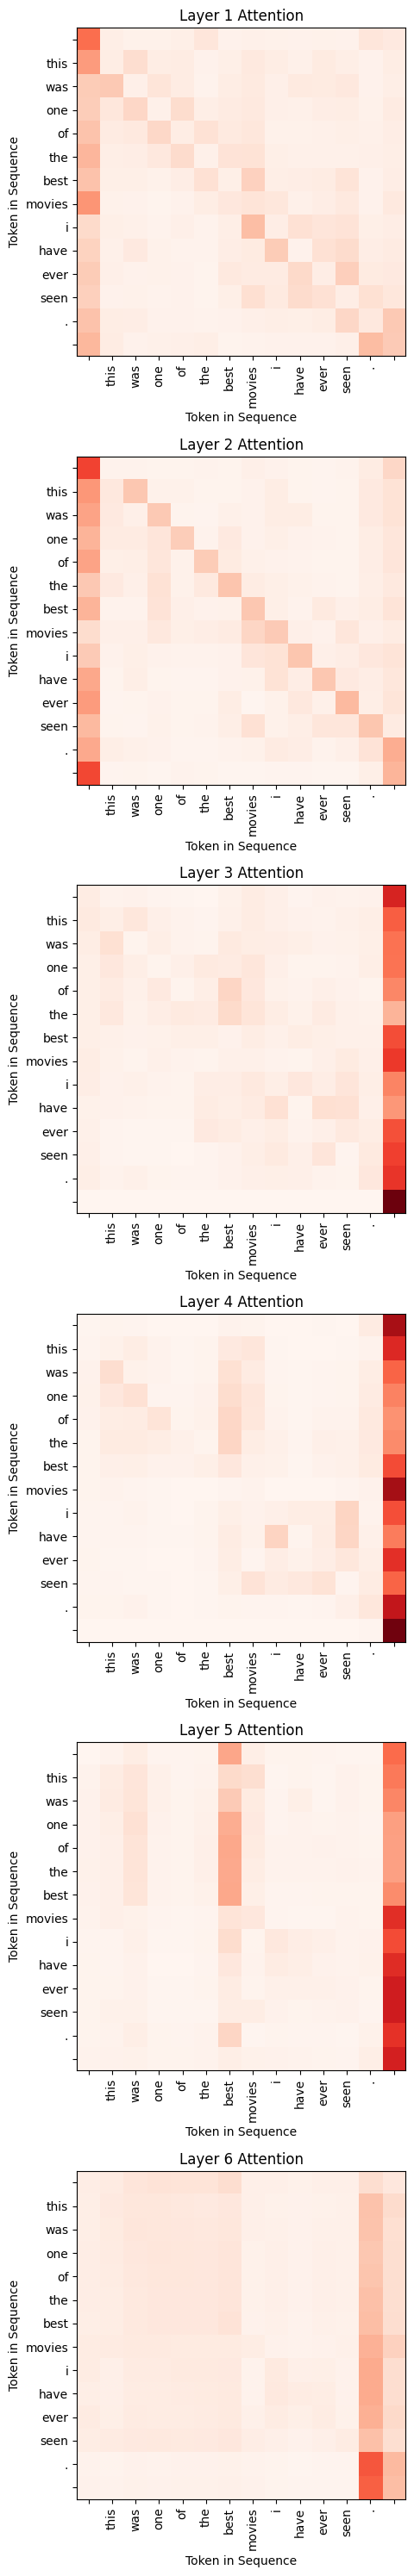

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# YOUR CODE HERE #

attention_matrices = []
for layer_idx in range(config.n_layers):
    # Concatenate tensors along the batch axis
    attention_tensor = torch.cat([a.squeeze(0) for a in model.attention_probs[layer_idx]], dim=0)

    avg_attention = attention_tensor.mean(dim=0)  # Average over the heads
    attention_matrices.append(avg_attention)


tokens = [tokenizer.decode([tok], skip_special_tokens=True) for tok in inputs['input_ids'][0]]

# Handling the possibility of one or multiple axes
fig, axes = plt.subplots(nrows=len(attention_matrices), figsize=(10, 5 * len(attention_matrices)))
if len(attention_matrices) == 1:
    axes = [axes]  

for i, ax in enumerate(axes):
    ax.imshow(attention_matrices[i].numpy(), cmap='Reds', vmin=0, vmax=1)
    ax.set_title(f'Layer {i + 1} Attention')
    ax.set_xlabel('Token in Sequence')
    ax.set_ylabel('Token in Sequence')
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens)

plt.tight_layout()
plt.show()
